# 第一部分 课程内容

* 教学目的

    金融统计学习方法这一节，将介绍三个重要的金融模型，本教程将介绍的是ARCH、GARCH金融模型。这是对之前介绍的ARIMA的进一步拓展，这里要作为重点介绍的是，如何用python来实现他们。对于没有接触过的人，提供了少许介绍，也帮助学过的人进行回忆。

    ARCH模型是获得2003年诺贝尔经济学奖的计量经济学成果之一。被认为是最集中反映了方差变化特点而被广泛应用于金融数据时间序列分析的模型。目前所有的波动率模型中,ARCH类模型无论从理论研究的深度还是从实证运用的广泛性来说都是独一无二的，广泛地用于验证金融理论中的规律描述以及金融市场的预测和决策。传统的计量经济学对时间序列变量的第二个假设假定时间序列变量的波动幅度（方差）是固定的，不符合实际，ARCH模型就是解决了这样的一个问题。

    相信经过之前的教程，你已经有了基本的python编程能力，python是个工具，使用这个工具的能力需要长时间的锻炼，如何运用工具来解决问题，将是更为长久的难题。
    
* 教学材料

    我们需要用到的数据是上证指数的k线数据，在1.2采集数据中有提到如何搜集
    
    我们将用到绘图包，数据分析基础包，统计包

## 1 ARCH是什么
### 1.1 波动率的特征
对于金融时间序列，波动率往往具有以下特征：
1. 存在**波动率聚集**现象。 即波动率在一段时间上高，一段时间上低
2. 波动率以连续时间变化，很少发生跳跃
3. 波动率不会发散到无穷，波动率往往是**平稳**的
4. 波动率对价格大幅上升和大幅下降的反应是不同的，这个现象为**杠杆效应**

### 1.2 ARCH的基本原理

在传统计量经济学模型中，干扰项的方差被假设为常数。但是许多经济时间序列呈现出波动的集聚性，在这种情况下假设方差为常数是不恰当的。

ARCH模型将当前一切可利用信息作为条件，并采用某种自回归形式来刻画方差的变异，对于一个时间序列而言，在不同时刻可利用的信息不同，而相应的条件方差也不同，利用ARCH模型，可以刻画出随时间而变异的条件方差。

### 1.3 ARCH模型

首先假设：
1. 资产收益率序列的扰动{$a_t$}是序列不相关的，但是不独立。
2. {$a_t$}的不独立性可以用其延迟值的简单二次函数来描述。

具体而言，一个ARCH\(m\)模型为：$$ \large a_t = \sigma_t\varepsilon_t\large \sigma_t^2 = \alpha_0 + \alpha_1a_{t-1}^2 + \cdots + \alpha_m a_{t-m}^2 \large \alpha_0 > 0; \forall i > 0, \alpha_i \geq 0 $$

其中，**$ \{\varepsilon_t\} $为均值为0，方差为1的独立同分布（iid）随机变量序列**，通常假定其服从标准正态分布。$ \sigma_t^2$为条件异方差。


### 1.4 ARCH模型效应

从上面模型的结构看，大的过去的平方“扰动”会导致信息$a_t$大的条件异方差。从而$a_t$有取绝对值较大的值的倾向。这意味着：**在ARCH的框架下，大的"扰动"会倾向于紧接着出现另一个大的"扰动"。这与波动率聚集的现象相似。**

所谓ARCH模型效应，也就是**条件异方差序列的序列相关性**

## 2 ARCH模型建立

ok，上面尽可能简单地介绍了ARCH的原理，下面主要介绍如何用python实现。

ARCH模型建立大致分为以下几步：
1. 通过检验数据的序列相关性建立一个均值方程，如有必要，对收益率序列建立一个计量经济模型（如ARMA）来消除任何线形依赖。
2. 对均值方程的残差进行ARCH效应检验
3. 如果具有ARCH效应，则建立波动率模型
4. 检验拟合的模型，如有必要则进行改进

arch库其实提供了现成的方法（后面会介绍），但是为了更好地理解ARCH，我们按流程来建模。

### 2.1 均值方程的建立

这里的均值方程可以简单认为是建立的ARMA(或ARIMA)模型，ARCH其实是在此基础上的一些“修正”。

接下来我们以上证指数日涨跌幅序列为例。由于后面的arch库均值方程只支持常数、零均值、AR模型，我们这里建立AR模型，方便对照。

注意这里使用了tushare，请参照课程1.2采集数据来使用。

In [2]:
# 相关库
from scipy import  stats
import statsmodels.api as sm  # 统计相关的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch  # 条件异方差模型相关的库
import tushare as ts
import seaborn as sns

                indexID  ticker porgFullName secShortName exchangeCD  \
tradeDate                                                              
2014-01-02  000001.ZICN       1      上海证券交易所         上证综指       XSHG   
2014-01-03  000001.ZICN       1      上海证券交易所         上证综指       XSHG   
2014-01-06  000001.ZICN       1      上海证券交易所         上证综指       XSHG   
2014-01-07  000001.ZICN       1      上海证券交易所         上证综指       XSHG   
2014-01-08  000001.ZICN       1      上海证券交易所         上证综指       XSHG   

             tradeDate  preCloseIndex  openIndex  lowestIndex  highestIndex  \
tradeDate                                                                     
2014-01-02  2014-01-02       2115.978   2112.126     2101.016      2113.110   
2014-01-03  2014-01-03       2109.387   2101.542     2075.899      2102.167   
2014-01-06  2014-01-06       2083.136   2078.684     2034.006      2078.684   
2014-01-07  2014-01-07       2045.709   2034.224     2029.246      2052.279   
2014-01-08  2014-01-0

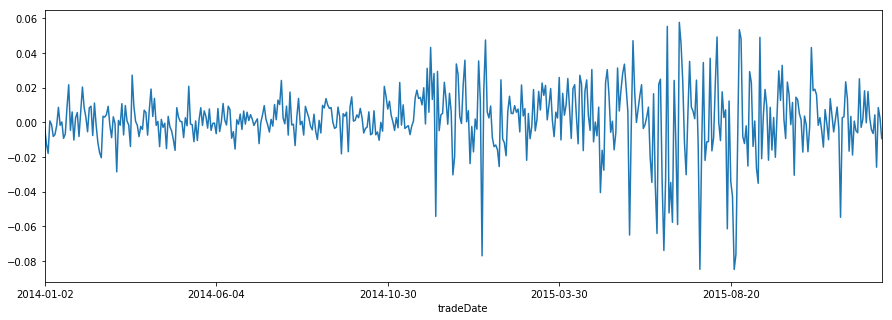

In [6]:
# 设置画布
sns.set_context({'figure.figsize': [20, 5]})
# 获取部分数据并展示
IndexData = pd.read_csv('../data/上证指数201401.csv')
IndexData = IndexData.set_index(IndexData['tradeDate'])
print(IndexData.head())

# 提取涨跌幅
data = np.array(IndexData['CHGPct'])
IndexData['CHGPct'].plot(figsize=(15,5))

首先检验平稳性，是否需要差分。 原假设$H_0$：序列为非平稳的，备择假设$H_1$:序列是平稳的。sm.tsa.stattools.adfuller返回的第一项是ADF检验值，第二项就是P值。

In [7]:
data = np.array(IndexData['CHGPct'])
t = sm.tsa.stattools.adfuller(data)  # ADF检验
print(t)
print("p-value: ", t[1])

(-6.995371592027627, 7.557757208256395e-10, 9, 479, {'1%': -3.44407586647939, '5%': -2.867592847097137, '10%': -2.5699939338217668}, -2397.7799005187326)
p-value:  7.557757208256395e-10


可以看出，p-value小于显著性水平，所以拒绝原假设，即序列是平稳的。

接下来我们建立AR\(p\)模型，先判定阶次

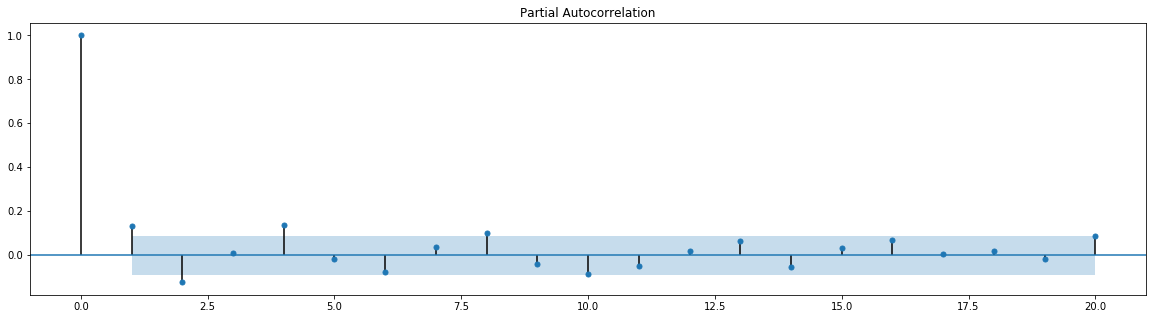

In [8]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(data,lags = 20,ax=ax1)

于是我们建立AR(8)模型，即均值方程

In [9]:
order = (8,0)
model = sm.tsa.ARMA(data,order).fit()

### 2.2 ARCH效应的检验

*todo*

我们利用[金融时间序列入门（一）](https://uqer.io/community/share/5790a091228e5b90cda2e2ea)中的混成检验（Ljung-Box),检验序列 **{$a_t^2$}** 的相关性，来判断是否具有ARCH效应

计算均值方程残差： $$ \large a_t = r_t - \mu_t$$

画出残差及残差的平方

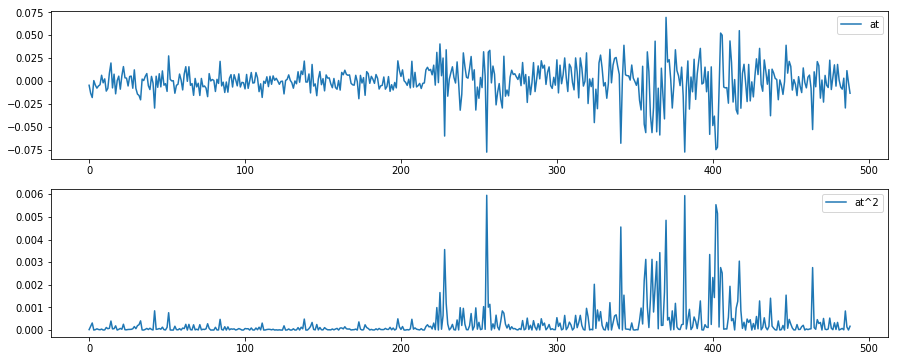

In [11]:
at = data - model.fittedvalues
at2 = np.square(at)
plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(at,label = 'at')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2')
plt.legend(loc=0)

然后对{$a_t^2$}序列进行混成检验： 原假设$H_0$:序列没有相关性，备择假设$H_1$:序列具有相关性

In [12]:
m = 25 # 我们检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.239755,28.281681,1.048839e-07
2.0,0.255332,60.423708,7.571093e-14
3.0,0.228797,86.285215,1.374866e-18
4.0,0.219143,110.059377,7.068515e-23
5.0,0.168783,124.191328,4.060688e-25
6.0,0.161525,137.160865,3.980435e-27
7.0,0.137504,146.579238,2.121364e-28
8.0,0.105541,152.139407,7.015660e-29
9.0,0.106755,157.840041,2.086518e-29


p-value小于显著性水平0.05，我们拒绝原假设，即认为序列具有相关性。因此具有ARCH效应。

### 2.3 ARCH模型的建立

首先讲讲ARCH模型的阶次，可以用{$a_t^2$}序列的偏自相关函数PACF来确定：

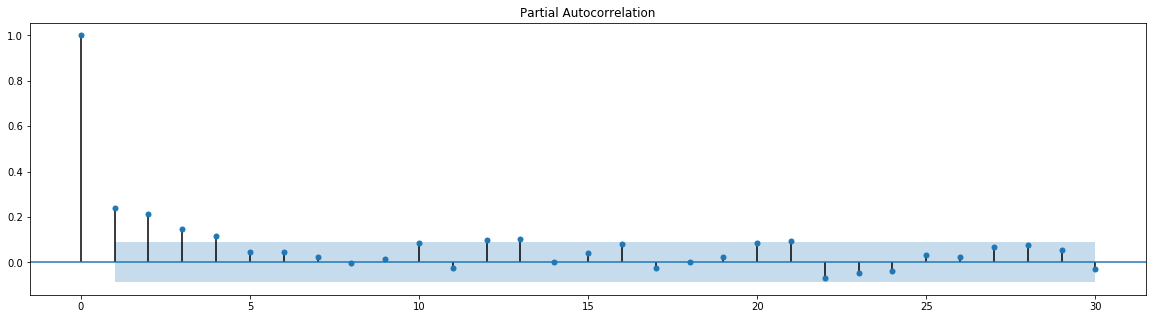

In [13]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(at2,lags = 30,ax=ax1)

由上面的图我们可以粗略定为4阶。然后建立AR(4)模型 $$ \large  \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + cdots + \alpha_4 a_{t-m}^2 \\ \large \eta =a_t^2 -  \sigma_t^2 \\ \large a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + cdots + \alpha_4 a_{t-m}^2 + \eta_t $$

后续的AR模型就不建立了。因为按照上述流程走下来非常麻烦，但是实际上并不困难。

事实上，**arch库**可以一步到位：

根据我们之前的分析，可以粗略选择**均值模型为AR(8)模型**，**波动率模型选择ARCH(4)模型**

In [15]:
train = data[:-10]
test = data[-10:]
print(train)
am = arch.arch_model(train,mean='AR',lags=8,vol='ARCH',p=4) 
res = am.fit()

[-3.1150e-03 -1.2445e-02 -1.7967e-02  7.8600e-04 -1.4540e-03 -8.1780e-03
 -7.0640e-03 -1.8550e-03  8.5980e-03 -1.7240e-03  1.7400e-04 -9.2660e-03
 -6.8310e-03  8.5670e-03  2.1628e-02 -4.6640e-03  5.9800e-03 -1.0267e-02
  2.5640e-03  5.5930e-03 -8.2110e-03  5.6140e-03  2.0333e-02  8.4390e-03
  2.9870e-03 -5.4760e-03  8.3140e-03  9.2480e-03 -7.6560e-03  1.1084e-02
 -1.7610e-03 -1.1731e-02 -1.7508e-02 -2.0449e-02  3.4580e-03  2.9880e-03
  4.3710e-03  9.2070e-03 -1.8130e-03 -8.8770e-03  3.1630e-03 -8.1100e-04
 -2.8594e-02  1.0460e-03 -1.7310e-03  1.0722e-02 -7.3160e-03  9.6460e-03
  7.5300e-04 -1.7090e-03 -1.3976e-02  2.7159e-02  9.1130e-03  4.9900e-04
 -1.7610e-03 -8.2770e-03 -2.3830e-03 -4.1170e-03  6.9610e-03  5.6300e-03
 -7.4240e-03  7.4030e-03  1.9163e-02  3.3140e-03  1.3805e-02 -1.7610e-03
  4.6800e-04 -1.4045e-02  1.6750e-03 -2.9630e-03 -5.4200e-04 -1.5217e-02
  3.3910e-03 -2.6290e-03 -5.0060e-03 -9.9730e-03 -1.6220e-02  8.4120e-03
  2.9780e-03  4.9100e-04  3.3800e-04 -8.8530e-03  2

/home/jovyan/.local/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [16]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.041
Mean Model:                        AR   Adj. R-squared:                  0.025
Vol Model:                       ARCH   Log-Likelihood:                1280.63
Distribution:                  Normal   AIC:                          -2533.26
Method:            Maximum Likelihood   BIC:                          -2475.09
                                        No. Observations:                  471
Date:                Tue, Mar 12 2019   Df Residuals:                      457
Time:                        04:07:23   Df Model:                           14
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      1.6925e-03  6.506e-04      2.602  9.281e-03 [4.174e-04,2.968e-03]
y[1]           0.1093  5.789e-02      1.889  5.891e-02  [-4.117e-03,  0.223]
y[2]          -0.1158  6.728e-02     -1.721  8.531e-02   [ -0.248,1.610e-02]
y[3]          -0.0724  6.549e-02     -1.105      0.269   [ -0.201,5.597e-02]
y[4]           0.0413  9.381e-02      0.440      0.660     [ -0.143,  0.225]
y[5]           0.0248  6.616e-02      0.374      0.708     [ -0.105,  0.154]
y[6]          -0.0786  7.435e-02     -1.058      0.290   [ -0.224,6.709e-02]
y[7]          -0.0613  6.596e-02     -0.929      0.353   [ -0.191,6.797e-02]
y[8]           0.0365  5.736e-02      0.637      0.524  [-7.590e-02,  0.149]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0660e-04  3.809e-05      2.798  5.135e-03 [3.194e-05,1.813e-04]
alpha[1]       0.1708      0.166      1.028      0.304     [ -0.155,  0.496]
alpha[2]       0.1948  9.038e-02      2.155  3.114e-02   [1.765e-02,  0.372]
alpha[3]       0.1708      0.118      1.445      0.148  [-6.080e-02,  0.402]
alpha[4]       0.1708      0.149      1.144      0.253     [ -0.122,  0.463]
============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

In [17]:
# todo 数据不同，模型也不同
res.params

Const       0.001693
y[1]        0.109337
y[2]       -0.115758
y[3]       -0.072393
y[4]        0.041279
y[5]        0.024758
y[6]       -0.078636
y[7]       -0.061307
y[8]        0.036522
omega       0.000107
alpha[1]    0.170802
alpha[2]    0.194790
alpha[3]    0.170802
alpha[4]    0.170802
Name: params, dtype: float64

todo

可以看出，我们的模型为：
$$ \large r_t = 0.0016 + 0.1163a_t - 0.0982a_{t-1} - 0.1171a_{t-2} + 0.0394a_{t-3} - 0.0149a_{t-4} - 0.01510a_{t-5} - 0.0994a_{t-6}+0.0128a_{t-7} $$
$$ \large \sigma_t^2 = 0.00006 + 0.0017a_{t-1}^2 + 0.4667 a_{t-2}^2 + 0.2340a_{t-3}^2 + 0.2977a_{t-4}^2$$

对上述模型，我们可以看出，上证指数的日收益率期望大约在0.16%。 模型的R-squared较小，拟合效果一般。

### 2.4 ARCH模型的预测

首先，我们来来看整体的预测结果的拟合情况，看看ARCH的威力。

In [18]:
print(res)

                           AR - ARCH Model Results                            
Dep. Variable:                      y   R-squared:                       0.041
Mean Model:                        AR   Adj. R-squared:                  0.025
Vol Model:                       ARCH   Log-Likelihood:                1280.63
Distribution:                  Normal   AIC:                          -2533.26
Method:            Maximum Likelihood   BIC:                          -2475.09
                                        No. Observations:                  471
Date:                Tue, Mar 12 2019   Df Residuals:                      457
Time:                        04:07:23   Df Model:                           14
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      1.6925e-03  6.506e-04      2.602  9.281e-03 [4.

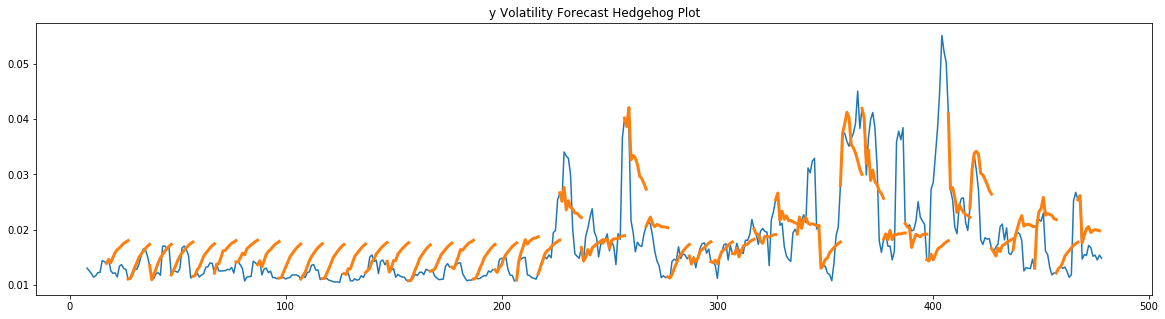

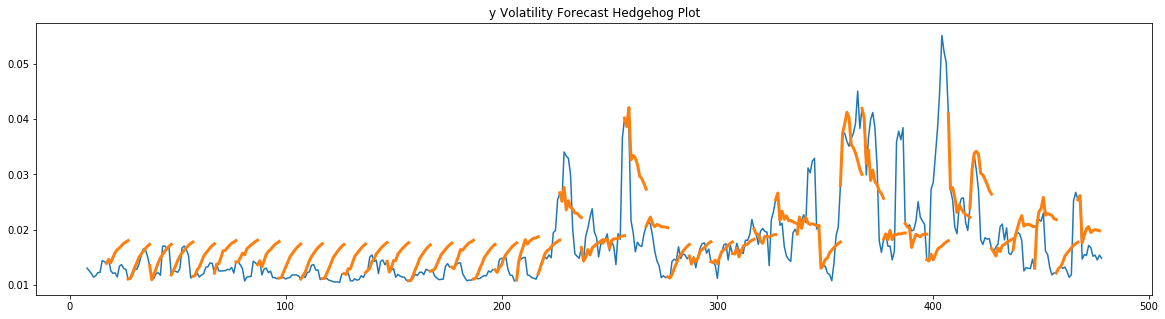

In [19]:
# todo 原作只有一张图，这里却有两张
res.hedgehog_plot()

可以看出，虽然具体值差距挺大，但是均值和方差的变化趋势是相似的。下面再看最后10个数据的预测情况

In [20]:
len(train)

479

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_mean', '_residual_variance', '_sim', '_variance', 'mean', 'residual_variance', 'simulations', 'variance']
<class 'arch.univariate.base.ARCHModelResult'> 
 <class 'arch.univariate.base.ARCHModelForecast'> <arch.univariate.base.ARCHModelForecastSimulation object at 0x7fc829d68550>


AttributeError: 'ARCHModelForecast' object has no attribute 'plot'

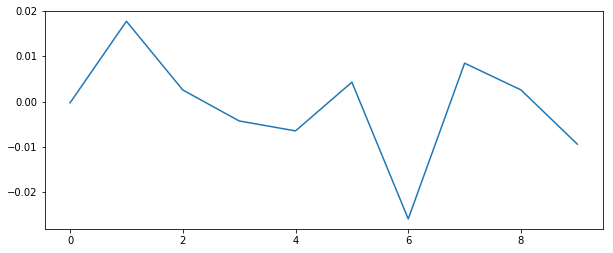

In [21]:
# todo
pre = res.forecast(horizon=10,start=478)
print(dir(pre))
print(type(res), '\n' ,type(res.forecast(horizon=10,start=478)),pre.simulations)
plt.figure(figsize=(10,4))
plt.plot(test,label='realValue')
pre.plot(label='predictValue')
plt.plot(np.zeros(10),label='zero')
plt.legend(loc=0)

可以看出，光从看涨看跌的角度去看，预测看涨看跌的正确率为60%，当然，其实模型更重要的功能是预测波动率，我们将在下章讲到。

## 3 GARCH模型与波动率预测

虽然ARCH模型简单，但为了充分刻画收益率的波动率过程，往往需要很多参数，例如上面用到ARCH(4)模型，有时会有更高的ARCH(m)模型。因此，Bollerslev(1986)年提出了一个推广形式，称为**广义的ARCH模型（GARCH）**

另$$\large a_t = r_t - \mu_t$$为$t$时刻的新息。若$a_t$满足下式：
$$ \large a_t = \sigma_t\varepsilon_t \\ \large \sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-i}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2 \\ \large \alpha_0 > 0; \forall i > 0, \alpha_i \geq 0 ,\beta_i \geq 0, (\alpha_i + \beta_i) < 1$$

其中，$ \{\varepsilon_t\} $为**均值为0，方差为1的独立同分布（iid）随机变量序列**。通常假定其服从**标准正态分布**或**标准化学生-t分布**。$ \sigma_t^2$为条件异方差。

则称$a_t$服从GARCH(m,s)模型。仔细观察公式，发现与ARMA模型很相似！

### 3.1 GARCH模型建立

与之前的ARCH模型建立过程类似，不过GARCH(m,s)的定阶较难，一般使用低阶模型如GARCH(1,1),GARCH(2,1),GARCH(1,2)等。

下面我们以之前的数据为例，构建GARCH模型，均值方程为AR(8)模型，波动率模型为GARCH(1,1)

In [42]:
train = data[:-10]
test = data[-10:]
am = arch.arch_model(train,mean='AR',lags=8,vol='GARCH') 
res = am.fit()

Iteration:      1,   Func. Count:     14,   Neg. LLF: 726.2581923593315
Iteration:      2,   Func. Count:     32,   Neg. LLF: 725.2983365093481
Iteration:      3,   Func. Count:     49,   Neg. LLF: 724.3455918946156
Iteration:      4,   Func. Count:     65,   Neg. LLF: 723.9467927045037
Iteration:      5,   Func. Count:     83,   Neg. LLF: 723.9160477249618
Iteration:      6,   Func. Count:     99,   Neg. LLF: 723.886278293821
Iteration:      7,   Func. Count:    114,   Neg. LLF: 723.2462030824751
Iteration:      8,   Func. Count:    130,   Neg. LLF: 722.4959436411968
Iteration:      9,   Func. Count:    147,   Neg. LLF: 722.4525841527282
Iteration:     10,   Func. Count:    162,   Neg. LLF: 722.3875545396866
Iteration:     11,   Func. Count:    177,   Neg. LLF: 721.4483681107754
Iteration:     12,   Func. Count:    194,   Neg. LLF: 721.4202397418153
Iteration:     13,   Func. Count:    210,   Neg. LLF: 721.3671920348734
Iteration:     14,   Func. Count:    225,   Neg. LLF: 721.0398089

In [43]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -720.322
Distribution:                  Normal   AIC:                           1464.64
Method:            Maximum Likelihood   BIC:                           1517.14
                                        No. Observations:                  587
Date:                Mon, Mar 04 2019   Df Residuals:                      575
Time:                        02:39:46   Df Model:                           12
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0206  3.006e-02      0.687      0.492 [-3.828e-02,7.956e-02]
y[1]          -0.0143  4.180e-02     -0.341      0.733 [-9.621e-02,6.766e-02]
y[2]       9.8158e-03  4.464e-02      0.220      0.826 [-7.768e-02,9.731e-02]
y[3]           0.0532  4.427e-02      1.201      0.230   [-3.360e-02,  0.140]
y[4]          -0.0654  4.176e-02     -1.566      0.117    [ -0.147,1.645e-02]
y[5]          -0.0159  4.680e-02     -0.340      0.734    [ -0.108,7.581e-02]
y[6]          -0.0172  4.487e-02     -0.383      0.701    [ -0.105,7.074e-02]
y[7]           0.0240  4.200e-02      0.572      0.567   [-5.828e-02,  0.106]
y[8]           0.0379  4.130e-02      0.917      0.359   [-4.309e-02,  0.119]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.9706e-03  7.682e-03      1.038      0.299 [-7.085e-03,2.303e-02]
alpha[1]       0.0612  4.055e-02      1.508      0.131   [-1.831e-02,  0.141]
beta[1]        0.9282  4.405e-02     21.070  1.494e-98      [  0.842,  1.015]
=============================================================================

Covariance estimator: robust
"""

In [44]:
res.params

Const       0.020642
y[1]       -0.014271
y[2]        0.009816
y[3]        0.053172
y[4]       -0.065388
y[5]       -0.015906
y[6]       -0.017207
y[7]        0.024039
y[8]        0.037860
omega       0.007971
alpha[1]    0.061155
beta[1]     0.928179
Name: params, dtype: float64

我们得到波动率模型：$$ \large \sigma_t^2 = 0.000007 + 0.1a_{t-1}^2 + 0.88\sigma_{t-1}^2$$

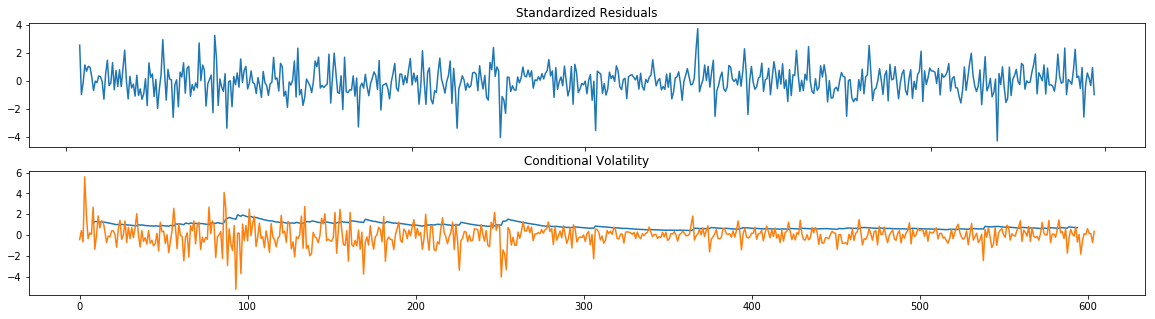

In [45]:
res.plot()
plt.plot(data)

观察上图，第一张图为标准化残差，近似平稳序列，说明模型在一定程度上是正确的； 

第二张图，绿色为原始收益率序列、蓝色为条件异方差序列，可以发现条件异方差很好得表现出了波动率。

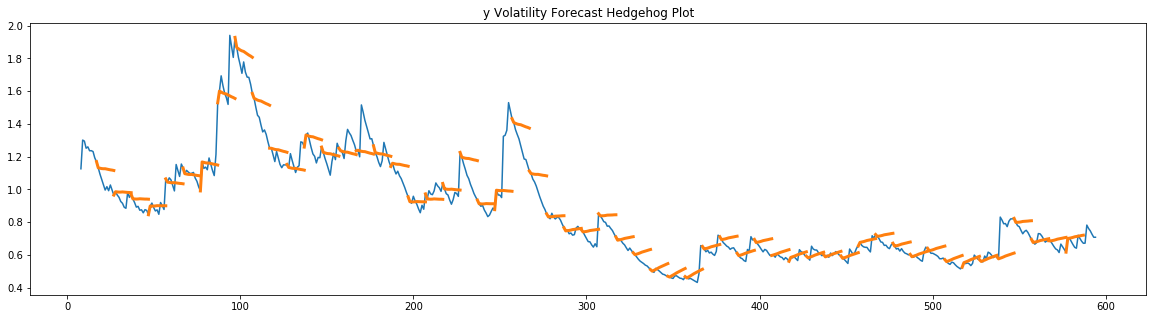

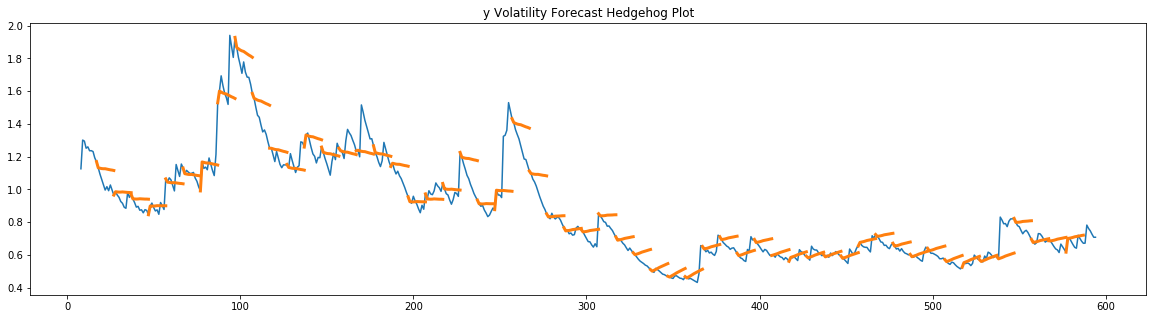

In [46]:
res.hedgehog_plot()

观察拟合图发现，在方差的还原上还是不错的。

### 3.2 波动率预测

上一章的预测直接预测了收益率，然而直接预测收益率准确度并不是很高，因此很多时候我们主要用来预测波动率，根据上面建立的波动率模型：
$$ \large \sigma_t^2 = 0.000007 + 0.1a_{t-1}^2 + 0.88\sigma_{t-1}^2$$
我们可以按照我们建立好的模型一步步计算。

根据模型：
$$ \large r_t = 0.00115 + 0.14861a_t - 0.09251a_{t-1} - 0.02050a_{t-2} + 0.11805a_{t-3} - 0.00009a_{t-4} - 0.07507a_{t-5} - 0.02683a_{t-6}+0.09734a_{t-7} $$
先计算$a_t$的预测值

In [ ]:
res.params

我们需要提取均值方程的系数向量$w$，再逐个计算$a_t$后面10个值

In [ ]:
ini = res.resid[-8:]
a = np.array(res.params[1:9])
w = a[::-1] # 系数
for i in range(10):
    new = test[i] - (res.params[0] + w.dot(ini[-8:]))
    ini = np.append(ini,new)
print len(ini)
at_pre = ini[-10:]
at_pre2 = at_pre**2
at_pre2

接着根据波动率模型预测波动率：$$ \large \sigma_t^2 = 0.000007 + 0.1a_{t-1}^2 + 0.88\sigma_{t-1}^2$$

In [ ]:
ini2 = res.conditional_volatility[-2:] #上两个条件异方差值

for i in range(10):
    new = 0.000007 + 0.1*at_pre2[i] + 0.88*ini2[-1]
    ini2 = np.append(ini2,new)
vol_pre = ini2[-10:]
vol_pre

我们将原始数据、条件异方差拟合数据及预测数据一起画出来，分析波动率预测情况

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(data,label='origin_data')
plt.plot(res.conditional_volatility,label='conditional_volatility')
x=range(479,489)
plt.plot(x,vol_pre,'.r',label='predict_volatility')
plt.legend(loc=0)

可以看出，对于接下来的1、2天的波动率预测较为接近，然后后面几天的预测逐渐偏小。

可惜的是arch库中没有找到直接调用的方法，只好自己来计算。

## 4 小结

本篇是时间序列入门系列的最后一篇，重点还是在基础的概念和python实现上。事实上要真学好这些模型，少不了更多的参考和实验。

# 第二部分 课程练习

1. 对于时间序列分析相信大家都有所心得了，请自我总结时间序列分析的要点，分析共性和特性
2. 请对ARIMA教程中的数据进行ARCH建模分析，并对比两个模型的效果，分析原因
3. 搜集数据对于数据分析来说也很重要，请尝试搜集苹果公司的股票数据

# 第三部分 延伸学习

由于容量问题，很多东西是没有办法介绍的，下面给出一些延伸学习的主题，请自行学习。

1. 下一个教程我们将介绍Fama的三因子模型，请先作了解
2. 在ARCH的基础上，还有很多扩展的或改进的模型如求和GARCH、GARCH-M模型、指数GARCH、EGARCH模型等等。对于波动率模型，还有比较常用的有随机波动率模型等，请自主学习
3. ARCH模型的提出也不是一蹴而就的，请查找资料学习ARCH模型的进化过程